In [1]:
import pandas as pd
import sys
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pickle
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import seaborn as sns
import gc
import itertools
import random
import math
from matplotlib.ticker import FormatStrFormatter
import ray
import shapley
sys.path.append('../')

In [12]:
class_risk_params = {
    'prevalence': 5*10**(-4),
    'vax_effectiveness': .715,
    'sensitivity': 0.6
}


aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    'nominal_breathe_virus_emitted_hourly': 3300,# corresponding to 10^8 copies / mL
    'nominal_talk_virus_emitted_hourly' : 27300,
    'nominal_sing_virus_emitted_hourly' : 330000,
    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}

"""
Difference of sets
"""
def Diff(li1, li2):
    li_dif = [i for i in li1 + li2 if i not in li1 or i not in li2]
    return li_dif

"""
Biased coin flipper
"""
def flip(p):
    return 1 if random.random() < p else 0

def exists_pos_in_class(frac_vax, N, params = class_risk_params):
    num_vax = np.floor(N*frac_vax)
    num_unvax = N-num_vax

    prev_unvax = params['prevalence']
    prev_vax = prev_unvax * (1-params['vax_effectiveness'])

    p_pos_unvax = prev_unvax * (1-params['sensitivity'])
    p_pos_vax = prev_vax * (1-params['sensitivity'])

    prob_exists_positive = 1 - (1-p_pos_unvax)**num_unvax * (1-p_pos_vax)**num_vax
    prob_one_positive = num_unvax * p_pos_unvax * (1-p_pos_unvax)**(num_unvax-1) * (1-p_pos_vax)**num_vax + \
                      (1-p_pos_unvax)**num_unvax * num_vax * p_pos_vax * (1-p_pos_vax)**(num_vax-1)
    approx_error = prob_exists_positive - prob_one_positive

    return prob_exists_positive, prob_one_positive, approx_error*N


def simulate_class_single_aerosol(room,vax_infected, unvax_infected, time,alpha,masked_status,class_type,room_vol,N,pixels_per_foot):
    room = room.reset_index()
    vax_infect_id = random.sample(list(room[room['seating'] == 'V']['index'].values), vax_infected)
    unvax_infect_id = random.sample(list(room[room['seating'] == 'U']['index'].values), unvax_infected)
    infected = room[room['index'].isin(np.append(vax_infect_id,unvax_infect_id))]
    uninfected = room[ (~room['index'].isin(np.append(vax_infect_id,unvax_infect_id))) & \
                      (room['seating'] != 'E')  ]
    if vax_infected == 1:
        source_status = 'V'
    elif unvax_infected == 1:
        source_status = 'U'
    infected_x = infected['x']
    infected_y = infected['y']
    
    unvax_aerosol_risk = 0.5*generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, class_type, params = aerosol_params)
    #p_exist = exists_pos_in_class(frac_vax, N, params = class_risk_params)[0]
    
    p_infections = []
    for i,row in uninfected.iterrows():
        x = row['x']
        y = row['y']
        v_infect = [x-infected_x,y - infected_y]
        v_vert = [0,10000]
        dot = v_infect[1]*v_vert[1]
        mag1 = 10000
        mag2 = np.sqrt((x-infected_x)**2+(y - infected_y)**2)
        theta =  math.acos(dot/(mag1*mag2))*180/math.pi
        
        susceptible_status = row['seating']
        
        susceptible_aerosol_risk = unvax_aerosol_risk 
        if susceptible_status == 'V':
            susceptible_aerosol_risk = susceptible_aerosol_risk * (1-class_risk_params['vax_effectiveness'])
        
        if theta < 90 + alpha:
       
            dist = np.sqrt((infected_x-x)**2+(infected_y-y)**2)
            p = updated_distance_to_prob(dist,susceptible_status,source_status,masked_status,time,pixels_per_foot)
            p = max(p,susceptible_aerosol_risk)
            p_infections.append(p)
        else:
            p_infections.append(susceptible_aerosol_risk)
            
    return np.sum(p_infections),unvax_aerosol_risk

def updated_distance_to_prob(d,susceptible_status,source_status,masked_status,time,pixels_per_foot): 
    d = d/pixels_per_foot*0.3048
    susceptible_const = 1
    source_const = 1
    masked_const = 1
    if susceptible_status == 'V':
        susceptible_const = 1 - class_risk_params['vax_effectiveness'] 
    if source_status == 'V':
        source_const = 0.29 
    if masked_status == True:
        masked_const = 0.8
        
    prob = 2.4*susceptible_const*(1-np.exp(-1 * source_const* masked_const * 0.0135 *time * (-0.1819*np.log(d)+0.43276)/d))
    prob = float(prob)
    return max(prob,0)

def generate_aerosol_risk(room_vol, vax_infected, unvax_infected, time, masked_status, class_type, params = aerosol_params):
    
    if class_type == 'breathe':
        v = params['nominal_breathe_virus_emitted_hourly'] 
    elif class_type == 'speak':
        v = params['nominal_talk_virus_emitted_hourly'] 
    elif class_type == 'sing':
        v = params['nominal_sing_virus_emitted_hourly'] 
    
    hourly_virus_array = np.array([v/1000, v/100, v/10, v, v*10, v*100, v*1000])

  # variables: source vaccinated? susceptible vaccinated? susceptible masked?
    dose_array = hourly_virus_array * params['inhale_air_rate'] / room_vol
    if masked_status == 1:
        dose_array = dose_array * 0.8
    if vax_infected == 1:
        dose_array = dose_array * 0.29 
  
    effective_dose_array = dose_array / params['dose_response_constant']

    unvax_susceptible_risk_array = 1 - np.exp(-effective_dose_array)

    #vax_susceptible_risk_array = (1 - class_risk_params['vax_effectiveness']) * unvax_susceptible_risk_array
    #susceptible_risk_array = unvax_susceptible_risk_array * (1-frac_vax) + vax_susceptible_risk_array * frac_vax
    #susceptible_risk = np.dot(susceptible_risk_array, np.array(params['viral_load_distribution']))
    #individual_susceptible_risk_over_time = 2.4*susceptible_risk * time
    
    unvax_susceptible_risk = np.dot(unvax_susceptible_risk_array, np.array(params['viral_load_distribution']))
    unvax_susceptible_risk_over_time = 2.4*unvax_susceptible_risk * time

    return unvax_susceptible_risk_over_time

In [13]:
def generate_clumpy_plan(N,p,room, clump_size = 3):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    room = room.drop('UnvaxSpot',axis = 1).reset_index()
    grid = room.copy()
    grid['seating'] = 'E'
    
    if Nunvax > 0:
        clump_size = min(clump_size,Nunvax)
        num_clumps = math.floor(Nunvax/clump_size)
        remainder = Nunvax - num_clumps*clump_size
        clump = 0
        while clump < (num_clumps):
            ind1 = np.random.choice(room['index'].values,replace = False)
            grid['seating'].loc[grid['index'] == ind1] = 'U'
            room = room.drop(ind1, axis = 0)
            x_temp = grid['x'].loc[grid['index'] == ind1].values[0]
            y_temp = grid['y'].loc[grid['index'] == ind1].values[0]  
            temp = room.copy()
            temp['dist_infected'] = ((temp['x'] -x_temp) ** 2 + (temp['y'] - y_temp) ** 2) ** 0.5
            temp = temp.sort_values('dist_infected', ascending = True).head(clump_size-1)
            grid['seating'].loc[grid['index'].isin(temp['index'].values)] = 'U'
            room = room.drop(temp['index'].values, axis = 0)
            clump = clump + 1
        remainder_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],remainder,replace = False)
        grid['seating'].loc[grid['index'].isin(remainder_ind)] = 'U'

    vax_ind = np.random.choice(grid['index'].loc[grid['seating'] == 'E'],Nvax,replace = False) 
    grid['seating'].loc[grid['index'].isin(vax_ind)] = 'V'
    
    return grid

def generate_random_plan(N,p,room):
    Nvax = round(N*p)
    Nunvax = N-Nvax
    
    room = room.drop('UnvaxSpot',axis = 1)
    grid = room.copy()
    grid = grid.reset_index()
    temp = list(np.append(np.append(np.repeat('V',Nvax),np.repeat('U',Nunvax)),np.repeat('E',len(grid)-Nvax-Nunvax)))
    random.shuffle(temp)
    grid['seating'] = temp
    return grid


# Load Room Plans

([], [])

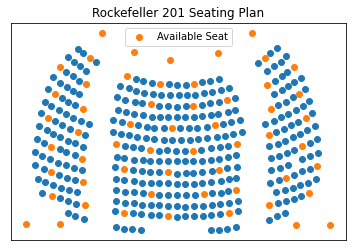

In [14]:
# Big Room
with open("../Data/rk201.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

big_pixels_per_foot = (2074-1575)/20
big_volume = 1684283

x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']



FA2020room = room.copy()
FA2020room['label'] = FA2020room.index

#label of seats used in 2020
indicies = [282,283,284,285, 286,287,288,289,290,365,238,270,273,110,362,358,227,222,260,104,100,348,352,207,20,250,89,
           93,76,80,189,193,172,163,339,334,321,168,25,2,61,65,51,14,121,138,149,308,312,299,294,144,124,34,40,36]
FA2020room['UnvaxSpot'] = 0
FA2020room['UnvaxSpot'].iloc[indicies] = 1
FA2020room.drop('label', axis =1,inplace = True)
FA2020room['seating'] = 'E'
FA2020room['seating'].loc[FA2020room['UnvaxSpot'] == 1] = 'U'
plt.figure()
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'])
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 1]['x'],FA2020room[FA2020room['UnvaxSpot'] == 1]['y'], label = 'Available Seat')
plt.title('Rockefeller 201 Seating Plan')
FA2020_subset = FA2020room[FA2020room['UnvaxSpot']==1 ].reset_index().drop('index', axis = 1)
big_plan = FA2020_subset.copy()
plt.legend()
plt.xticks([])
plt.yticks([])
#print([big_pixels_per_foot,big_volume,big_plan])

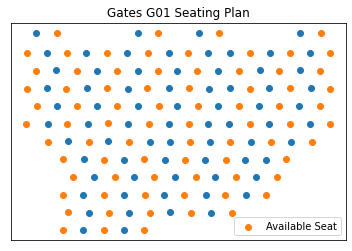

In [15]:
with open("../Data/gtsg01.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

medium_pixels_per_foot = (2834-2082)/20
medium_volume = 1087931

x_coord = [-i.x +3000 for i in layout['Middles']]
y_coord = [-i.y +3000 for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']
room_subset = room[room['UnvaxSpot'] == 1].reset_index().drop('index',axis = 1)
medium_plan = room_subset.copy()

plt.scatter(room[room['UnvaxSpot'] == 0]['x'],room[room['UnvaxSpot'] == 0]['y'])
plt.scatter(room[room['UnvaxSpot'] == 1]['x'],room[room['UnvaxSpot'] == 1]['y'], label = 'Available Seat')
plt.title('Gates G01 Seating Plan')
plt.xticks([])
plt.yticks([])
plt.legend()

([], [])

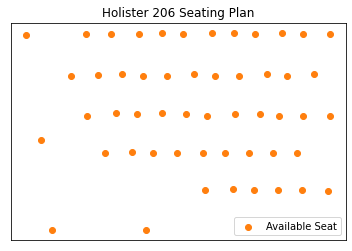

In [16]:
# Small Room
with open("../Data/hls206.pickle" , 'rb') as handle:
    layout = pickle.load(handle)

small_pixels_per_foot = (2014-1260)/15
small_volume = 222004

x_coord = [i.x for i in layout['Middles']]
y_coord = [i.y for i in layout['Middles']]
room = pd.DataFrame(np.column_stack((x_coord,y_coord)), columns = ['x','y'])
room['UnvaxSpot'] = layout['In Solution']


small_plan = room.copy()


plt.figure()
plt.scatter(small_plan[small_plan['UnvaxSpot'] == 0]['x'],small_plan[small_plan['UnvaxSpot'] == 0]['y'])
plt.scatter(small_plan[small_plan['UnvaxSpot'] == 1]['x'],small_plan[small_plan['UnvaxSpot'] == 1]['y'],  label = 'Available Seat')
plt.title('Holister 206 Seating Plan')
plt.legend()
plt.xticks([])
plt.yticks([])

#print([small_pixels_per_foot,small_volume,small_plan])

V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64
V    35
U    15
E     6
Name: seating, dtype: int64
V    35
E    27
U    15
Name: seating, dtype: int64
V    35
U    15
E     2
Name: seating, dtype: int64


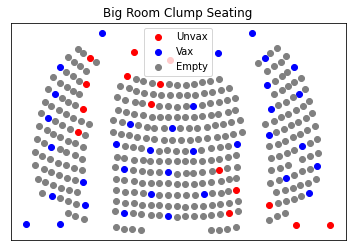

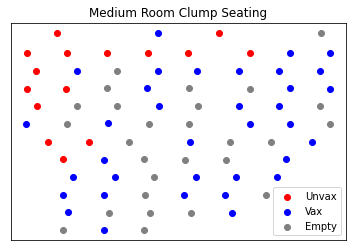

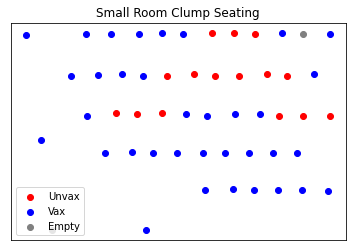

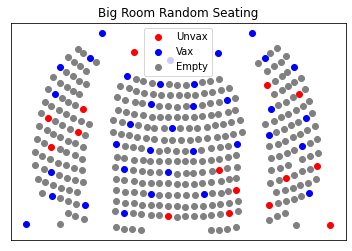

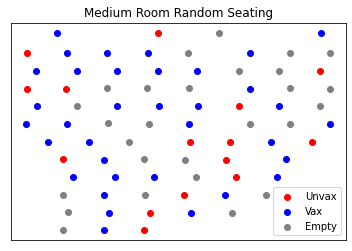

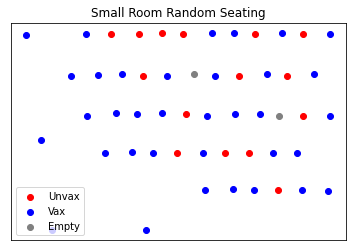

In [17]:
grid = generate_clumpy_plan(50,.7,big_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_clumpy_plan(50,.7,medium_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())


grid = generate_clumpy_plan(50,.7,small_plan,3)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Clump Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,big_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.scatter(FA2020room[FA2020room['UnvaxSpot'] == 0]['x'],FA2020room[FA2020room['UnvaxSpot'] == 0]['y'],color = 'grey')
plt.title('Big Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,medium_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Medium Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

grid = generate_random_plan(50,.7,small_plan)
plt.figure()
plt.scatter(grid[grid['seating'] == 'U']['x'],grid[grid['seating'] == 'U']['y'], label = 'Unvax',color = 'red')
plt.scatter(grid[grid['seating'] == 'V']['x'],grid[grid['seating'] == 'V']['y'], label = 'Vax',color = 'blue')
plt.scatter(grid[grid['seating'] == 'E']['x'],grid[grid['seating'] == 'E']['y'], label = 'Empty',color = 'grey')
plt.title('Small Room '+ 'Random Seating')
plt.legend()
plt.xticks([])
plt.yticks([])
print(grid['seating'].value_counts())

### Simulator

In [18]:
#General Parameters
seating_function = generate_clumpy_plan
p_range = [0.7,0.8,0.9,1.0]
N = 50
time = 1


#Arguments
#[masked_status, room, room_vol,pixels_per_foot,class_type,label]
args = [[True, small_plan, small_volume, small_pixels_per_foot, 'breathe', 'mask_small_breathe'],
[True, small_plan, small_volume, small_pixels_per_foot, 'speak', 'mask_small_speak'],
[True, small_plan, small_volume, small_pixels_per_foot, 'sing','mask_small_sing'],
[False, small_plan, small_volume, small_pixels_per_foot, 'breathe','nomask_small_breathe'],
[False, small_plan, small_volume, small_pixels_per_foot, 'speak','nomask_small_speak'],
[False, small_plan, small_volume, small_pixels_per_foot, 'sing','nomask_small_sing'],
[True, medium_plan, medium_volume, medium_pixels_per_foot, 'breathe','mask_medium_breathe'],
[True, medium_plan, medium_volume, medium_pixels_per_foot,  'speak','mask_medium_speak'],
[True, medium_plan, medium_volume, medium_pixels_per_foot, 'sing', 'mask_medium_sing'],
[False, medium_plan, medium_volume, medium_pixels_per_foot, 'breathe', 'nomask_medium_breathe'],
[False, medium_plan, medium_volume, medium_pixels_per_foot, 'speak', 'nomask_medium_speak'],
[False, medium_plan, medium_volume, medium_pixels_per_foot, 'sing', 'nomask_medium_sing'],
[True, big_plan, big_volume, big_pixels_per_foot, 'breathe', 'mask_big_breathe'],
[True, big_plan, big_volume, big_pixels_per_foot,  'speak','mask_big_speak'],
[True, big_plan, big_volume, big_pixels_per_foot, 'sing','mask_big_sing'],
[False, big_plan, big_volume, big_pixels_per_foot, 'breathe', 'nomask_big_breathe'],
[False, big_plan, big_volume, big_pixels_per_foot, 'speak','nomask_big_speak'],
[False, big_plan, big_volume, big_pixels_per_foot, 'sing','nomask_big_sing']]


In [19]:
@ray.remote
def parallel_wrapper(p):
    trial = 0
    results = []
    results_aerosol = []
    while trial < 500:
        grid = seating_function(N,p,room)
        p_generate = (1-class_risk_params['vax_effectiveness'])*p/(1-class_risk_params['vax_effectiveness']*p)
        ind = flip(p_generate)
        if sum(grid['seating'] == 'V') == 0:
            ind = 0
        elif sum(grid['seating'] == 'U') == 0:
            ind = 1
        
        infect,aerosol = simulate_class_single_aerosol(grid,ind, 1-ind, time,15,masked_status,class_type,room_vol,N,pixels_per_foot)
        results.append(infect)
        results_aerosol.append(aerosol)
        trial = trial + 1
    return [p,np.mean(results),np.std(results), np.mean(results_aerosol)]

In [20]:
import warnings
warnings.filterwarnings("ignore")
final_results = {}
for arg in args:
    print(arg[-1])
    masked_status = arg[0]
    room = arg[1]
    room_vol = arg[2]
    pixels_per_foot = arg[3]
    class_type = arg[4]
    label = arg[5]
    
    ray.shutdown()
    ray.init(log_to_driver=False)
    result_ids = []
    for p in p_range:
        result_ids.append(parallel_wrapper.remote(p))    
    results = ray.get(result_ids)  
    ray.shutdown()
    results = pd.DataFrame(results, columns = ['p','mean','std','unvax_aerosol'])
    final_results[label] = results

mask_small_breathe


2021-08-02 12:26:44,679	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


mask_small_speak


2021-08-02 12:27:32,517	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


mask_small_sing


2021-08-02 12:28:18,057	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_small_breathe


2021-08-02 12:29:05,546	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_small_speak


2021-08-02 12:29:53,375	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_small_sing


2021-08-02 12:30:39,731	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


mask_medium_breathe


2021-08-02 12:31:33,526	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


mask_medium_speak


2021-08-02 12:32:19,750	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


mask_medium_sing


2021-08-02 12:33:05,407	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_medium_breathe


2021-08-02 12:33:52,816	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_medium_speak


2021-08-02 12:34:40,105	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_medium_sing


2021-08-02 12:35:30,590	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


mask_big_breathe


2021-08-02 12:36:16,905	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


mask_big_speak


2021-08-02 12:37:05,423	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


mask_big_sing


2021-08-02 12:37:50,523	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_big_breathe


2021-08-02 12:38:36,447	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_big_speak


2021-08-02 12:39:22,418	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_big_sing


2021-08-02 12:40:11,543	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


In [21]:
with open('sim_results/COVID_delta_sims_instructor.pickle', 'wb') as handle:
    pickle.dump(final_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [22]:
mask_small_breathe = final_results['mask_small_breathe']
mask_small_speak = final_results['mask_small_speak']
mask_small_sing = final_results['mask_small_sing']
nomask_small_breathe = final_results['nomask_small_breathe']
nomask_small_speak = final_results['nomask_small_speak']
nomask_small_sing = final_results['nomask_small_sing']

mask_medium_breathe = final_results['mask_medium_breathe']
mask_medium_speak = final_results['mask_medium_speak']
mask_medium_sing = final_results['mask_medium_sing']
nomask_medium_breathe = final_results['nomask_medium_breathe']
nomask_medium_speak = final_results['nomask_medium_speak']
nomask_medium_sing = final_results['nomask_medium_sing']

mask_big_breathe = final_results['mask_big_breathe']
mask_big_speak = final_results['mask_big_speak']
mask_big_sing = final_results['mask_big_sing']
nomask_big_breathe = final_results['nomask_big_breathe']
nomask_big_speak = final_results['nomask_big_speak']
nomask_big_sing = final_results['nomask_big_sing']


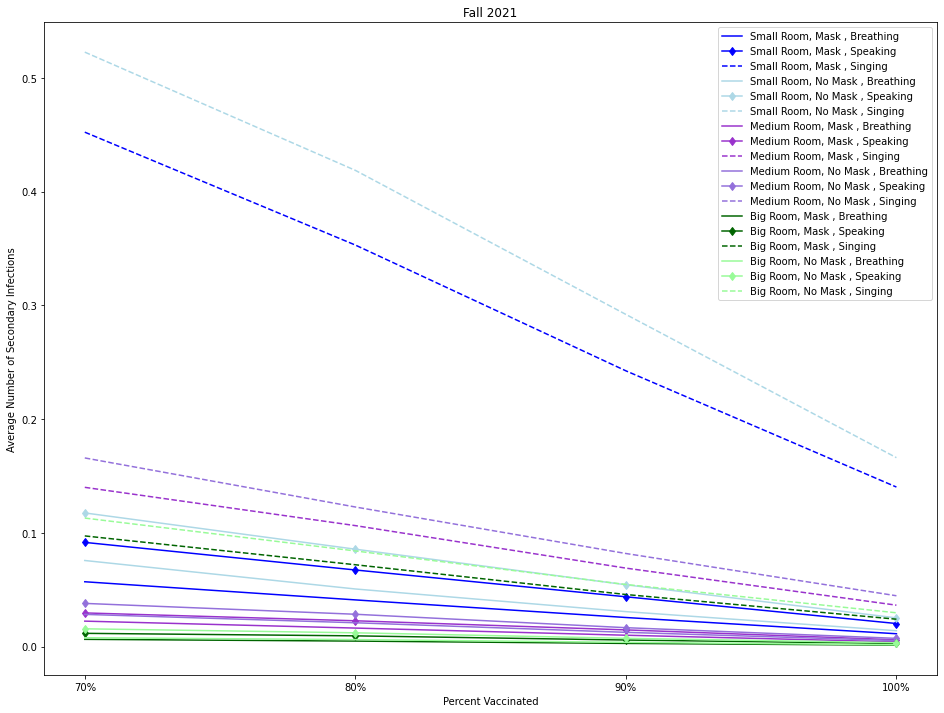

In [23]:
plt.figure(figsize = (16,12))
mark = 'd'


mask_small_breathe = mask_small_breathe[mask_small_breathe['p']>=.4]
mask_small_speak = mask_small_speak[mask_small_speak['p']>=.4]
mask_small_sing = mask_small_sing[mask_small_sing['p']>=.4]
nomask_small_breathe = nomask_small_breathe[nomask_small_breathe['p']>=.4]
nomask_small_speak = nomask_small_speak[nomask_small_speak['p']>=.4]
nomask_small_sing = nomask_small_sing[nomask_small_sing['p']>=.4]

mask_medium_breathe = mask_medium_breathe[mask_medium_breathe['p']>=.4]
mask_medium_speak = mask_medium_speak[mask_medium_speak['p']>=.4]
mask_medium_sing = mask_medium_sing[mask_medium_sing['p']>=.4]
nomask_medium_breathe = nomask_medium_breathe[nomask_medium_breathe['p']>=.4]
nomask_medium_speak = nomask_medium_speak[nomask_medium_speak['p']>=.4]
nomask_medium_sing = nomask_medium_sing[nomask_medium_sing['p']>=.4]

mask_big_breathe = mask_big_breathe[mask_big_breathe['p']>=.4]
mask_big_speak = mask_big_speak[mask_big_speak['p']>=.4]
mask_big_sing = mask_big_sing[mask_big_sing['p']>=.4]
nomask_big_breathe = nomask_big_breathe[nomask_big_breathe['p']>=.4]
nomask_big_speak = nomask_big_speak[nomask_big_speak['p']>=.4]
nomask_big_sing = nomask_big_sing[nomask_big_sing['p']>=.4]



plt.plot(mask_small_breathe['p'],mask_small_breathe['mean'],label = 'Small Room, Mask , Breathing', color = 'blue')
plt.plot(mask_small_speak['p'],mask_small_speak['mean'], label = 'Small Room, Mask , Speaking', color = 'blue', marker = mark)
plt.plot(mask_small_sing['p'],mask_small_sing['mean'],label = 'Small Room, Mask , Singing', color = 'blue', linestyle = '--')
plt.plot(nomask_small_breathe['p'],nomask_small_breathe['mean'],label = 'Small Room, No Mask , Breathing', color = 'lightblue')
plt.plot(nomask_small_speak['p'],nomask_small_speak['mean'], label = 'Small Room, No Mask , Speaking', color = 'lightblue', marker = mark)
plt.plot(nomask_small_sing['p'],nomask_small_sing['mean'],label = 'Small Room, No Mask , Singing', color = 'lightblue', linestyle = '--')


plt.plot(mask_medium_breathe['p'],mask_medium_breathe['mean'],label = 'Medium Room, Mask , Breathing', color = 'darkorchid')
plt.plot(mask_medium_speak['p'],mask_medium_speak['mean'], label = 'Medium Room, Mask , Speaking', color = 'darkorchid', marker = mark)
plt.plot(mask_medium_sing['p'],mask_medium_sing['mean'],label = 'Medium Room, Mask , Singing', color = 'darkorchid', linestyle = '--')
plt.plot(nomask_medium_breathe['p'],nomask_medium_breathe['mean'],label = 'Medium Room, No Mask , Breathing', color = 'mediumpurple')
plt.plot(nomask_medium_speak['p'],nomask_medium_speak['mean'], label = 'Medium Room, No Mask , Speaking', color = 'mediumpurple', marker = mark)
plt.plot(nomask_medium_sing['p'],nomask_medium_sing['mean'],label = 'Medium Room, No Mask , Singing', color = 'mediumpurple', linestyle = '--')

plt.plot(mask_big_breathe['p'],mask_big_breathe['mean'],label = 'Big Room, Mask , Breathing', color = 'darkgreen')
plt.plot(mask_big_speak['p'],mask_big_speak['mean'], label = 'Big Room, Mask , Speaking', color = 'darkgreen', marker = mark)
plt.plot(mask_big_sing['p'],mask_big_sing['mean'],label = 'Big Room, Mask , Singing', color = 'darkgreen', linestyle = '--')
plt.plot(nomask_big_breathe['p'],nomask_big_breathe['mean'],label = 'Big Room, No Mask , Breathing', color = 'palegreen')
plt.plot(nomask_big_speak['p'],nomask_big_speak['mean'], label = 'Big Room, No Mask , Speaking', color = 'palegreen', marker = mark)
plt.plot(nomask_big_sing['p'],nomask_big_sing['mean'],label = 'Big Room, No Mask , Singing', color = 'palegreen', linestyle = '--')





plt.legend()

plt.title('Fall 2021')
plt.xlabel('Percent Vaccinated')
plt.xticks(ticks = [.7,.8,.9,1], labels = ['70%', '80%','90%','100%'])
plt.ylabel('Average Number of Secondary Infections')
plt.legend()

# Updated Plots

In [24]:
mask_small_breathe = mask_small_breathe[mask_small_breathe['p']>=.7]
mask_small_speak = mask_small_speak[mask_small_speak['p']>=.7]
mask_small_sing = mask_small_sing[mask_small_sing['p']>=.7]
nomask_small_breathe = nomask_small_breathe[nomask_small_breathe['p']>=.7]
nomask_small_speak = nomask_small_speak[nomask_small_speak['p']>=.7]
nomask_small_sing = nomask_small_sing[nomask_small_sing['p']>=.7]

mask_medium_breathe = mask_medium_breathe[mask_medium_breathe['p']>=.7]
mask_medium_speak = mask_medium_speak[mask_medium_speak['p']>=.7]
mask_medium_sing = mask_medium_sing[mask_medium_sing['p']>=.7]
nomask_medium_breathe = nomask_medium_breathe[nomask_medium_breathe['p']>=.7]
nomask_medium_speak = nomask_medium_speak[nomask_medium_speak['p']>=.7]
nomask_medium_sing = nomask_medium_sing[nomask_medium_sing['p']>=.7]

mask_big_breathe = mask_big_breathe[mask_big_breathe['p']>=.7]
mask_big_speak = mask_big_speak[mask_big_speak['p']>=.7]
mask_big_sing = mask_big_sing[mask_big_sing['p']>=.7]
nomask_big_breathe = nomask_big_breathe[nomask_big_breathe['p']>=.7]
nomask_big_speak = nomask_big_speak[nomask_big_speak['p']>=.7]
nomask_big_sing = nomask_big_sing[nomask_big_sing['p']>=.7]

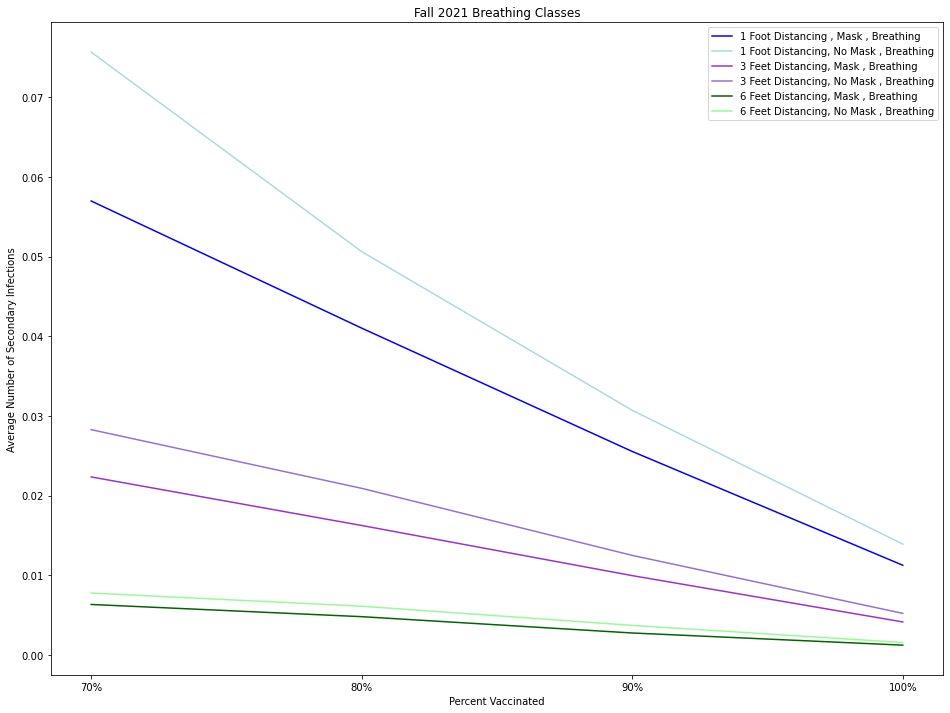

In [25]:
plt.figure(figsize = (16,12))
plt.plot(mask_small_breathe['p'],mask_small_breathe['mean'],label = '1 Foot Distancing , Mask , Breathing', color = 'blue')
plt.plot(nomask_small_breathe['p'],nomask_small_breathe['mean'],label = '1 Foot Distancing, No Mask , Breathing', color = 'lightblue')
plt.plot(mask_medium_breathe['p'],mask_medium_breathe['mean'],label = '3 Feet Distancing, Mask , Breathing', color = 'darkorchid')
plt.plot(nomask_medium_breathe['p'],nomask_medium_breathe['mean'],label = '3 Feet Distancing, No Mask , Breathing', color = 'mediumpurple')
plt.plot(mask_big_breathe['p'],mask_big_breathe['mean'],label = '6 Feet Distancing, Mask , Breathing', color = 'darkgreen')
plt.plot(nomask_big_breathe['p'],nomask_big_breathe['mean'],label = '6 Feet Distancing, No Mask , Breathing', color = 'palegreen')
plt.title('Fall 2021 Breathing Classes')
plt.xlabel('Percent Vaccinated')
plt.xticks(ticks = [.7,.8,.9,1], labels = [ '70%', '80%','90%','100%'])
plt.ylabel('Average Number of Secondary Infections')
plt.legend()

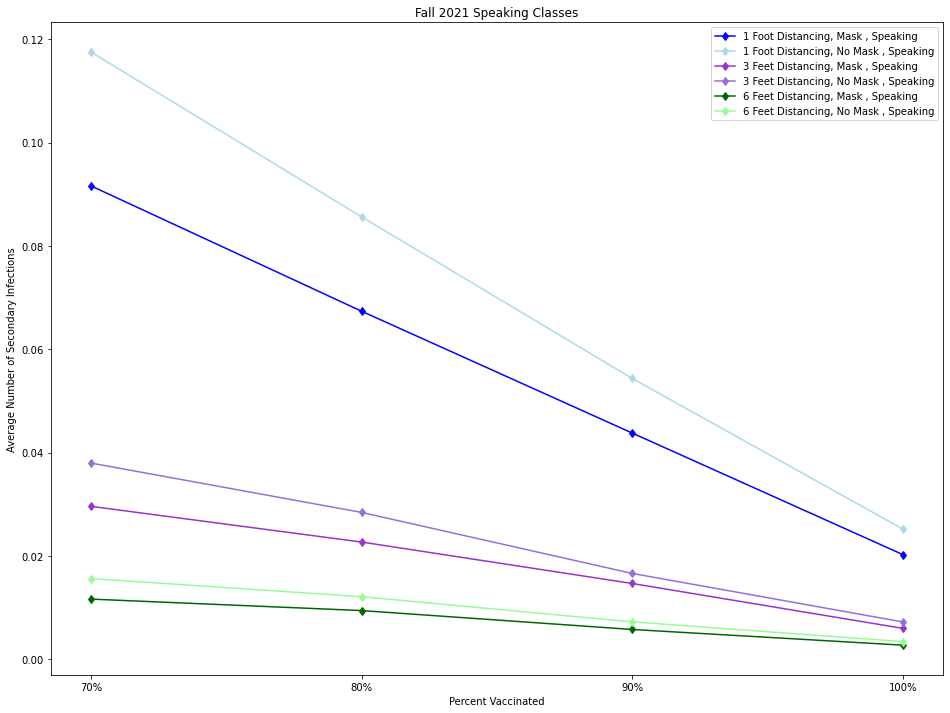

In [26]:
plt.figure(figsize = (16,12))
plt.plot(mask_small_speak['p'],mask_small_speak['mean'], label = '1 Foot Distancing, Mask , Speaking', color = 'blue', marker = mark)
plt.plot(nomask_small_speak['p'],nomask_small_speak['mean'], label = '1 Foot Distancing, No Mask , Speaking', color = 'lightblue', marker = mark)
plt.plot(mask_medium_speak['p'],mask_medium_speak['mean'], label = '3 Feet Distancing, Mask , Speaking', color = 'darkorchid', marker = mark)
plt.plot(nomask_medium_speak['p'],nomask_medium_speak['mean'], label = '3 Feet Distancing, No Mask , Speaking', color = 'mediumpurple', marker = mark)
plt.plot(mask_big_speak['p'],mask_big_speak['mean'], label = '6 Feet Distancing, Mask , Speaking', color = 'darkgreen', marker = mark)
plt.plot(nomask_big_speak['p'],nomask_big_speak['mean'], label = '6 Feet Distancing, No Mask , Speaking', color = 'palegreen', marker = mark)
plt.title('Fall 2021 Speaking Classes')
plt.xlabel('Percent Vaccinated')
plt.xticks(ticks = [.7,.8,.9,1], labels = [ '70%', '80%','90%','100%'])
plt.ylabel('Average Number of Secondary Infections')
plt.legend()

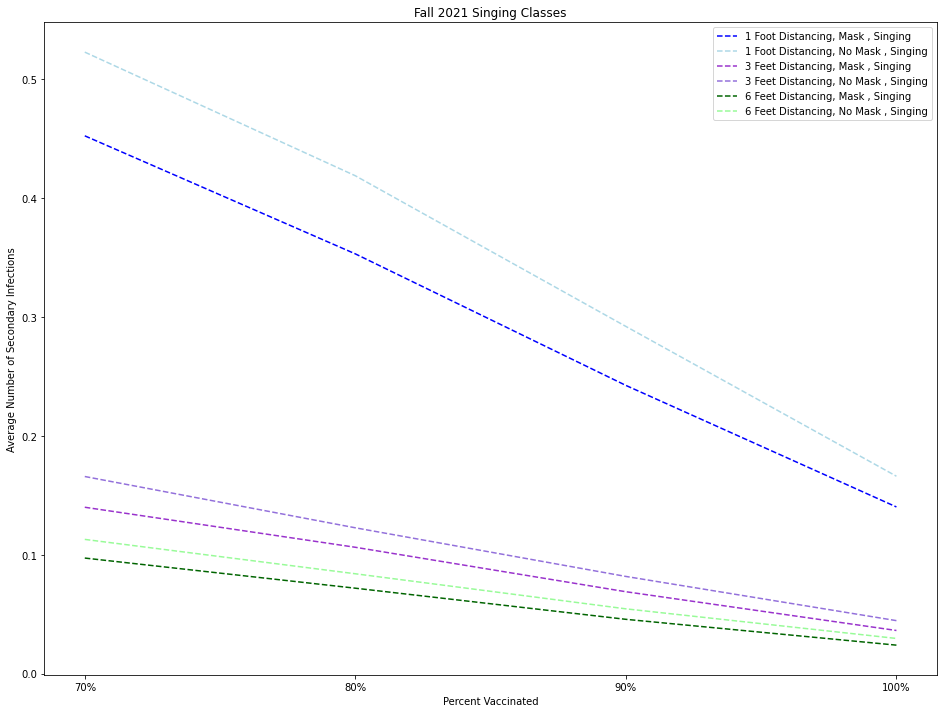

In [27]:
plt.figure(figsize = (16,12))

plt.plot(mask_small_sing['p'],mask_small_sing['mean'],label = '1 Foot Distancing, Mask , Singing', color = 'blue', linestyle = '--')
plt.plot(nomask_small_sing['p'],nomask_small_sing['mean'],label = '1 Foot Distancing, No Mask , Singing', color = 'lightblue', linestyle = '--')
plt.plot(mask_medium_sing['p'],mask_medium_sing['mean'],label = '3 Feet Distancing, Mask , Singing', color = 'darkorchid', linestyle = '--')
plt.plot(nomask_medium_sing['p'],nomask_medium_sing['mean'],label = '3 Feet Distancing, No Mask , Singing', color = 'mediumpurple', linestyle = '--')
plt.plot(mask_big_sing['p'],mask_big_sing['mean'],label = '6 Feet Distancing, Mask , Singing', color = 'darkgreen', linestyle = '--')
plt.plot(nomask_big_sing['p'],nomask_big_sing['mean'],label = '6 Feet Distancing, No Mask , Singing', color = 'palegreen', linestyle = '--')

plt.title('Fall 2021 Singing Classes')
plt.xlabel('Percent Vaccinated')
plt.xticks(ticks = [.7,.8,.9,1], labels = [ '70%', '80%','90%','100%'])
plt.ylabel('Average Number of Secondary Infections')
plt.legend()

# Instructor Risk

In [28]:
VE  = class_risk_params['vax_effectiveness']

In [29]:
mask_small_breathe['vax_aerosol'] = mask_small_breathe['unvax_aerosol']*(1- VE)
nomask_small_breathe['vax_aerosol'] = nomask_small_breathe['unvax_aerosol']*(1- VE)

mask_small_speak['vax_aerosol'] = mask_small_speak['unvax_aerosol']*(1- VE)
nomask_small_speak['vax_aerosol'] = nomask_small_speak['unvax_aerosol']*(1- VE)

Text(0.5, 1.0, 'Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, Breathing Class')

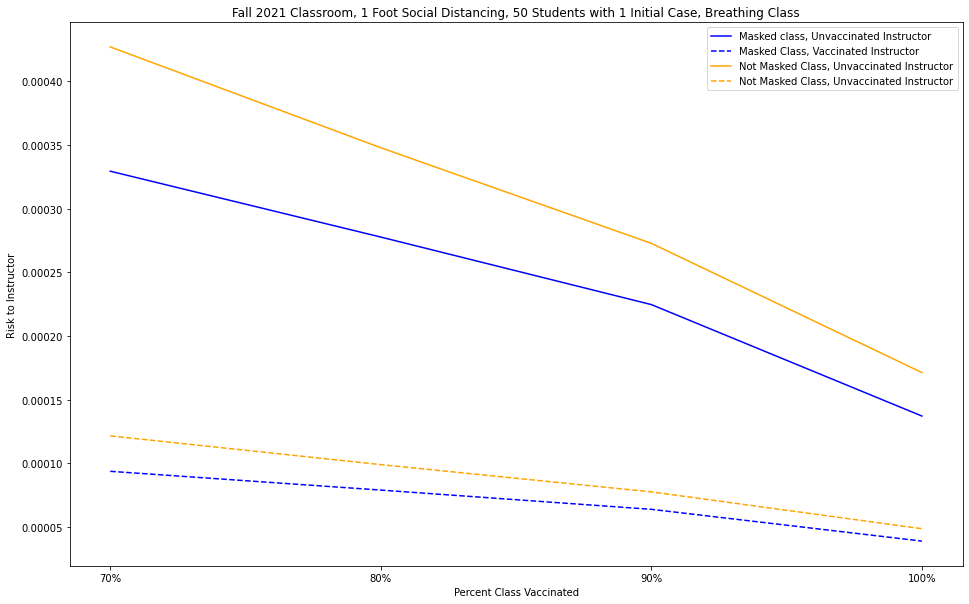

In [30]:
plt.figure(figsize = (16,10))
plt.plot(mask_small_breathe['p'],mask_small_breathe['unvax_aerosol'], label = 'Masked class, Unvaccinated Instructor', color = 'blue')
plt.plot(mask_small_breathe['p'],mask_small_breathe['vax_aerosol'], label = 'Masked Class, Vaccinated Instructor', color = 'blue', linestyle = 'dashed')
plt.plot(nomask_small_breathe['p'],nomask_small_breathe['unvax_aerosol'], label = 'Not Masked Class, Unvaccinated Instructor', color = 'orange')
plt.plot(nomask_small_breathe['p'],nomask_small_breathe['vax_aerosol'], label = 'Not Masked Class, Unvaccinated Instructor', color = 'orange', linestyle = 'dashed')
plt.xlabel('Percent Class Vaccinated')
plt.xticks(ticks = [.7,.8,.9,1], labels = [ '70%', '80%','90%','100%'])
plt.legend()
plt.ylabel('Risk to Instructor')
plt.title('Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, Breathing Class')

Text(0.5, 1.0, 'Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, Speaking Class')

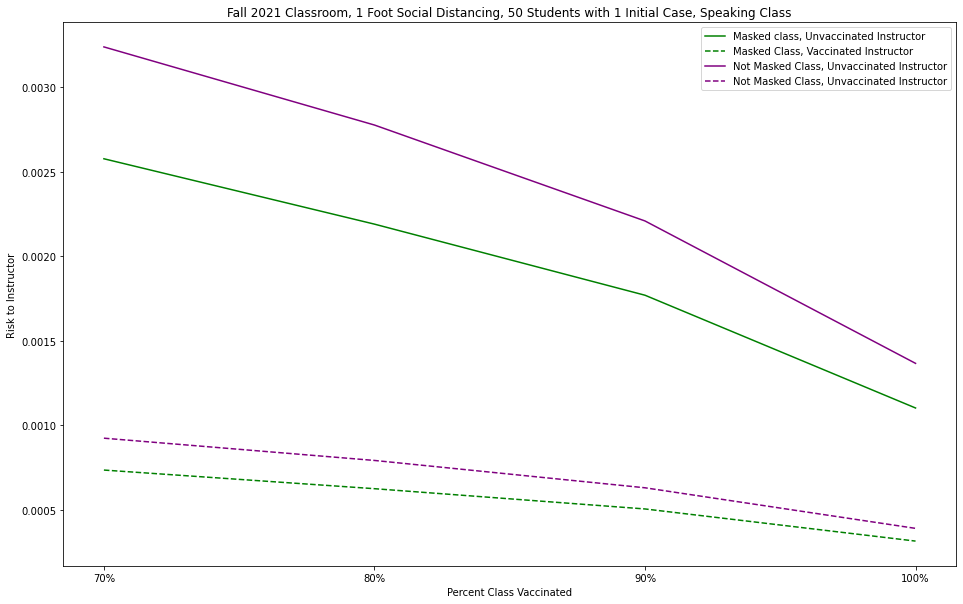

In [31]:
plt.figure(figsize = (16,10))
plt.plot(mask_small_speak['p'],mask_small_speak['unvax_aerosol'], label = 'Masked class, Unvaccinated Instructor', color = 'green')
plt.plot(mask_small_speak['p'],mask_small_speak['vax_aerosol'], label = 'Masked Class, Vaccinated Instructor', color = 'green', linestyle = 'dashed')
plt.plot(nomask_small_speak['p'],nomask_small_speak['unvax_aerosol'], label = 'Not Masked Class, Unvaccinated Instructor', color = 'purple')
plt.plot(nomask_small_speak['p'],nomask_small_speak['vax_aerosol'], label = 'Not Masked Class, Unvaccinated Instructor', color = 'purple', linestyle = 'dashed')
plt.xlabel('Percent Class Vaccinated')
plt.xticks(ticks = [.7,.8,.9,1], labels = [ '70%', '80%','90%','100%'])
plt.legend()
plt.ylabel('Risk to Instructor')
plt.title('Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, Speaking Class')

# FWS simulation

In [32]:
#General Parameters
seating_function = generate_clumpy_plan
p_range = [0.7,0.8,0.9,1.0]
N = 10
time = 1
#Arguments
#[masked_status, room, room_vol,pixels_per_foot,class_type,label]
args = [[True, small_plan, small_volume, small_pixels_per_foot, 'speak', 'mask_small_speak'],
[False, small_plan, small_volume, small_pixels_per_foot, 'speak', 'nomask_small_speak']]

aerosol_params = {
    'inhale_air_rate': 6.8,
    'dose_response_constant': 1440,
    'nominal_breathe_virus_emitted_hourly': 3300,# corresponding to 10^8 copies / mL
    'nominal_talk_virus_emitted_hourly' :  (3300 + 1/10*27300),
    'nominal_sing_virus_emitted_hourly' : 330000,
    'viral_load_distribution': [0.12, 0.22, 0.3, 0.23, 0.103, 0.0236, 0.0034] # over orders of magnitude from 10^5 to 10^11
}

import warnings
warnings.filterwarnings("ignore")
final_results = {}
for arg in args:
    print(arg[-1])
    masked_status = arg[0]
    room = arg[1]
    room_vol = arg[2]
    pixels_per_foot = arg[3]
    class_type = arg[4]
    label = arg[5]
    
    ray.shutdown()
    ray.init(log_to_driver=False)
    result_ids = []
    for p in p_range:
        result_ids.append(parallel_wrapper.remote(p))    
    results = ray.get(result_ids)  
    ray.shutdown()
    results = pd.DataFrame(results, columns = ['p','mean','std','unvax_aerosol'])
    final_results[label] = results

mask_small_speak


2021-08-02 13:09:50,297	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


nomask_small_speak


2021-08-02 13:10:04,065	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


Text(0.5, 1.0, 'Fall 2021 Classroom, 1 Foot Social Distancing, 50 Students with 1 Initial Case, Speaking Class')

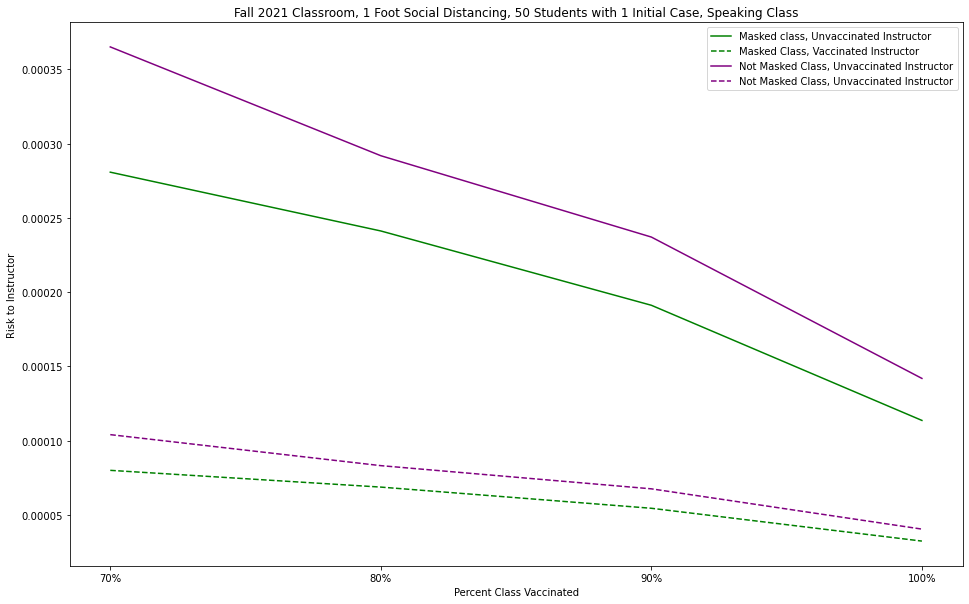

In [98]:
mask_small_speak = final_results['mask_small_speak']
nomask_small_speak = final_results['nomask_small_speak']
mask_small_speak['vax_aerosol'] = mask_small_speak['unvax_aerosol']*(1- VE)
nomask_small_speak['vax_aerosol'] = nomask_small_speak['unvax_aerosol']*(1- VE)
plt.figure(figsize = (16,10))
plt.plot(mask_small_speak['p'],mask_small_speak['unvax_aerosol'], label = 'Masked class, Unvaccinated Instructor', color = 'green')
plt.plot(mask_small_speak['p'],mask_small_speak['vax_aerosol'], label = 'Masked Class, Vaccinated Instructor', color = 'green', linestyle = 'dashed')
plt.plot(nomask_small_speak['p'],nomask_small_speak['unvax_aerosol'], label = 'Not Masked Class, Unvaccinated Instructor', color = 'purple')
plt.plot(nomask_small_speak['p'],nomask_small_speak['vax_aerosol'], label = 'Not Masked Class, Unvaccinated Instructor', color = 'purple', linestyle = 'dashed')
plt.xlabel('Percent Class Vaccinated')
plt.xticks(ticks = [.7,.8,.9,1], labels = [ '70%', '80%','90%','100%'])
plt.legend()
plt.ylabel('Risk to Instructor')
plt.title('Fall 2021 Classroom, 1 Foot Social Distancing, 10 Students with 1 Initial Case, 1 Student Speaking')